In [ ]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.ticker as mtickerb
from mhm_dataprocessing import *

#font segoe ui
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Segoe UI'

### Analysis of mHM simulated Recharge

In [114]:
# Paths
src = "W:/VUB/_main_research/mHM/mhm_outputs/mhm_RMI"
shapefile_path = "W:/VUB/_main_research/mHM/mhm_belgium/be_shp/be.shp"

# Open the NetCDF dataset using xarray
recharge = xr.open_dataset(src + "/mhm_recharge.nc")

# Load Belgium's shapefile with geopandas
be_shp = gpd.read_file(shapefile_path)

#Precipition, Temperature and Evapotranspiration
pre = xr.open_dataset("W:/VUB/_main_research/mHM/mhm_belgium/RMI/meteo/pre/pre.nc")
temp = xr.open_dataset("W:/VUB/_main_research/mHM/mhm_belgium/RMI/meteo/tavg/tavg.nc")
pet = xr.open_dataset("W:/VUB/_main_research/mHM/mhm_belgium/RMI/meteo/pet/pet.nc")

#set -9999 to nan and slice the data to match the duration of the recharge data
pre = pre.where(pre != -9999).sel(time=slice(recharge.time[0], recharge.time[-1]))
temp = temp.where(temp != -9999).sel(time=slice(recharge.time[0], recharge.time[-1]))
pet = pet.where(pet != -9999).sel(time=slice(recharge.time[0], recharge.time[-1]))

In [89]:
#use recharge values to mask data outside the domain area
mask = recharge['recharge'].isel(time=0)
#mask the data
mhm_mask = mask.where(mask > 0.001)*0 + 1
#Apply mask to mhm fluxes
be_data = recharge.where(mhm_mask == 1)

In [90]:
monthly_recharge = be_data.resample(time="ME").sum()

#annual average recharge across all years
annual_recharge = monthly_recharge.groupby('time.year').sum('time')

#average annual recharge
annual_recharge_mean = annual_recharge.mean('year')

### Annual Recharge

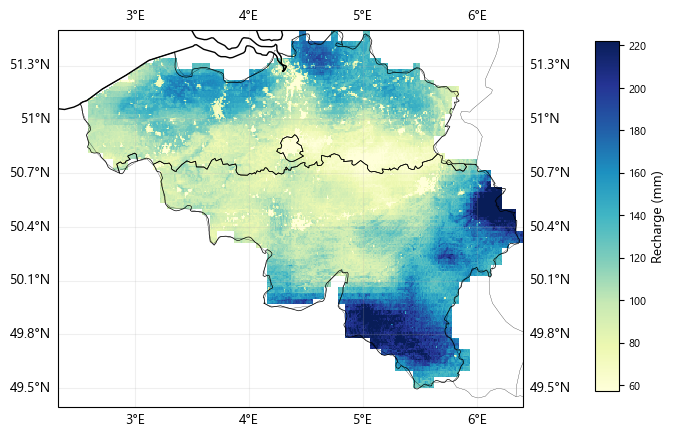

In [176]:
# Let's plot the first timestep where recharge > 0

# Create a mask for values where recharge > 0
recharge_ds = annual_recharge_mean['recharge']
recharge_masked = recharge_ds.where(recharge_ds > 0, drop=True)

# Set the projection
projection = ccrs.PlateCarree()

# Set up the plot with Cartopy projection
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(6, 5))

# Add gridlines
gl = ax.gridlines(crs=projection, draw_labels=True, alpha=0.2)
gl.xlabels_top = False

#define custom color palette
#cmap = matplotlib.colors.ListedColormap(['#ff7f0e', '#FFFF00', '#BBF90F', '#00FF00','#15B01A','#029386','#069AF3'])
cmap = 'YlGnBu'

# Plot the data for the first timestep where recharge > 0
im = recharge_masked.plot(
    robust=True,
    ax=ax,
    cmap=cmap,
    add_colorbar=False
)

# Add coastlines
ax.coastlines()
# Add political boundaries (will display global borders)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), lw=0.2)

# Plot Belgium's boundaries
be_shp.boundary.plot(ax=ax, color='k', lw=.5)

#add cb
cbar_ax = fig.add_axes([1.02, 0.15, 0.04, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='Recharge (mm)')
cbar_ax.tick_params(labelsize=8)

# Show the plot
plt.show()


#### Group data by Meteorological seasons

Calculate the total of the ds for each meteorological season: DJF,MAM,JJA,SON.  
This is done for daily data, where the variable is cummulative e.g precipitation, recharge, PET etc.

For variables like temperature that need to be averaged, use the default groupby season in xarray

In [92]:
#use the function from mhm_dataprocessing to extract the seasonal totals
seasonal_recharge = extract_seasonal_totals(recharge)
seasonal_pre = extract_seasonal_totals(pre)
seasonal_pet = extract_seasonal_totals(pet)

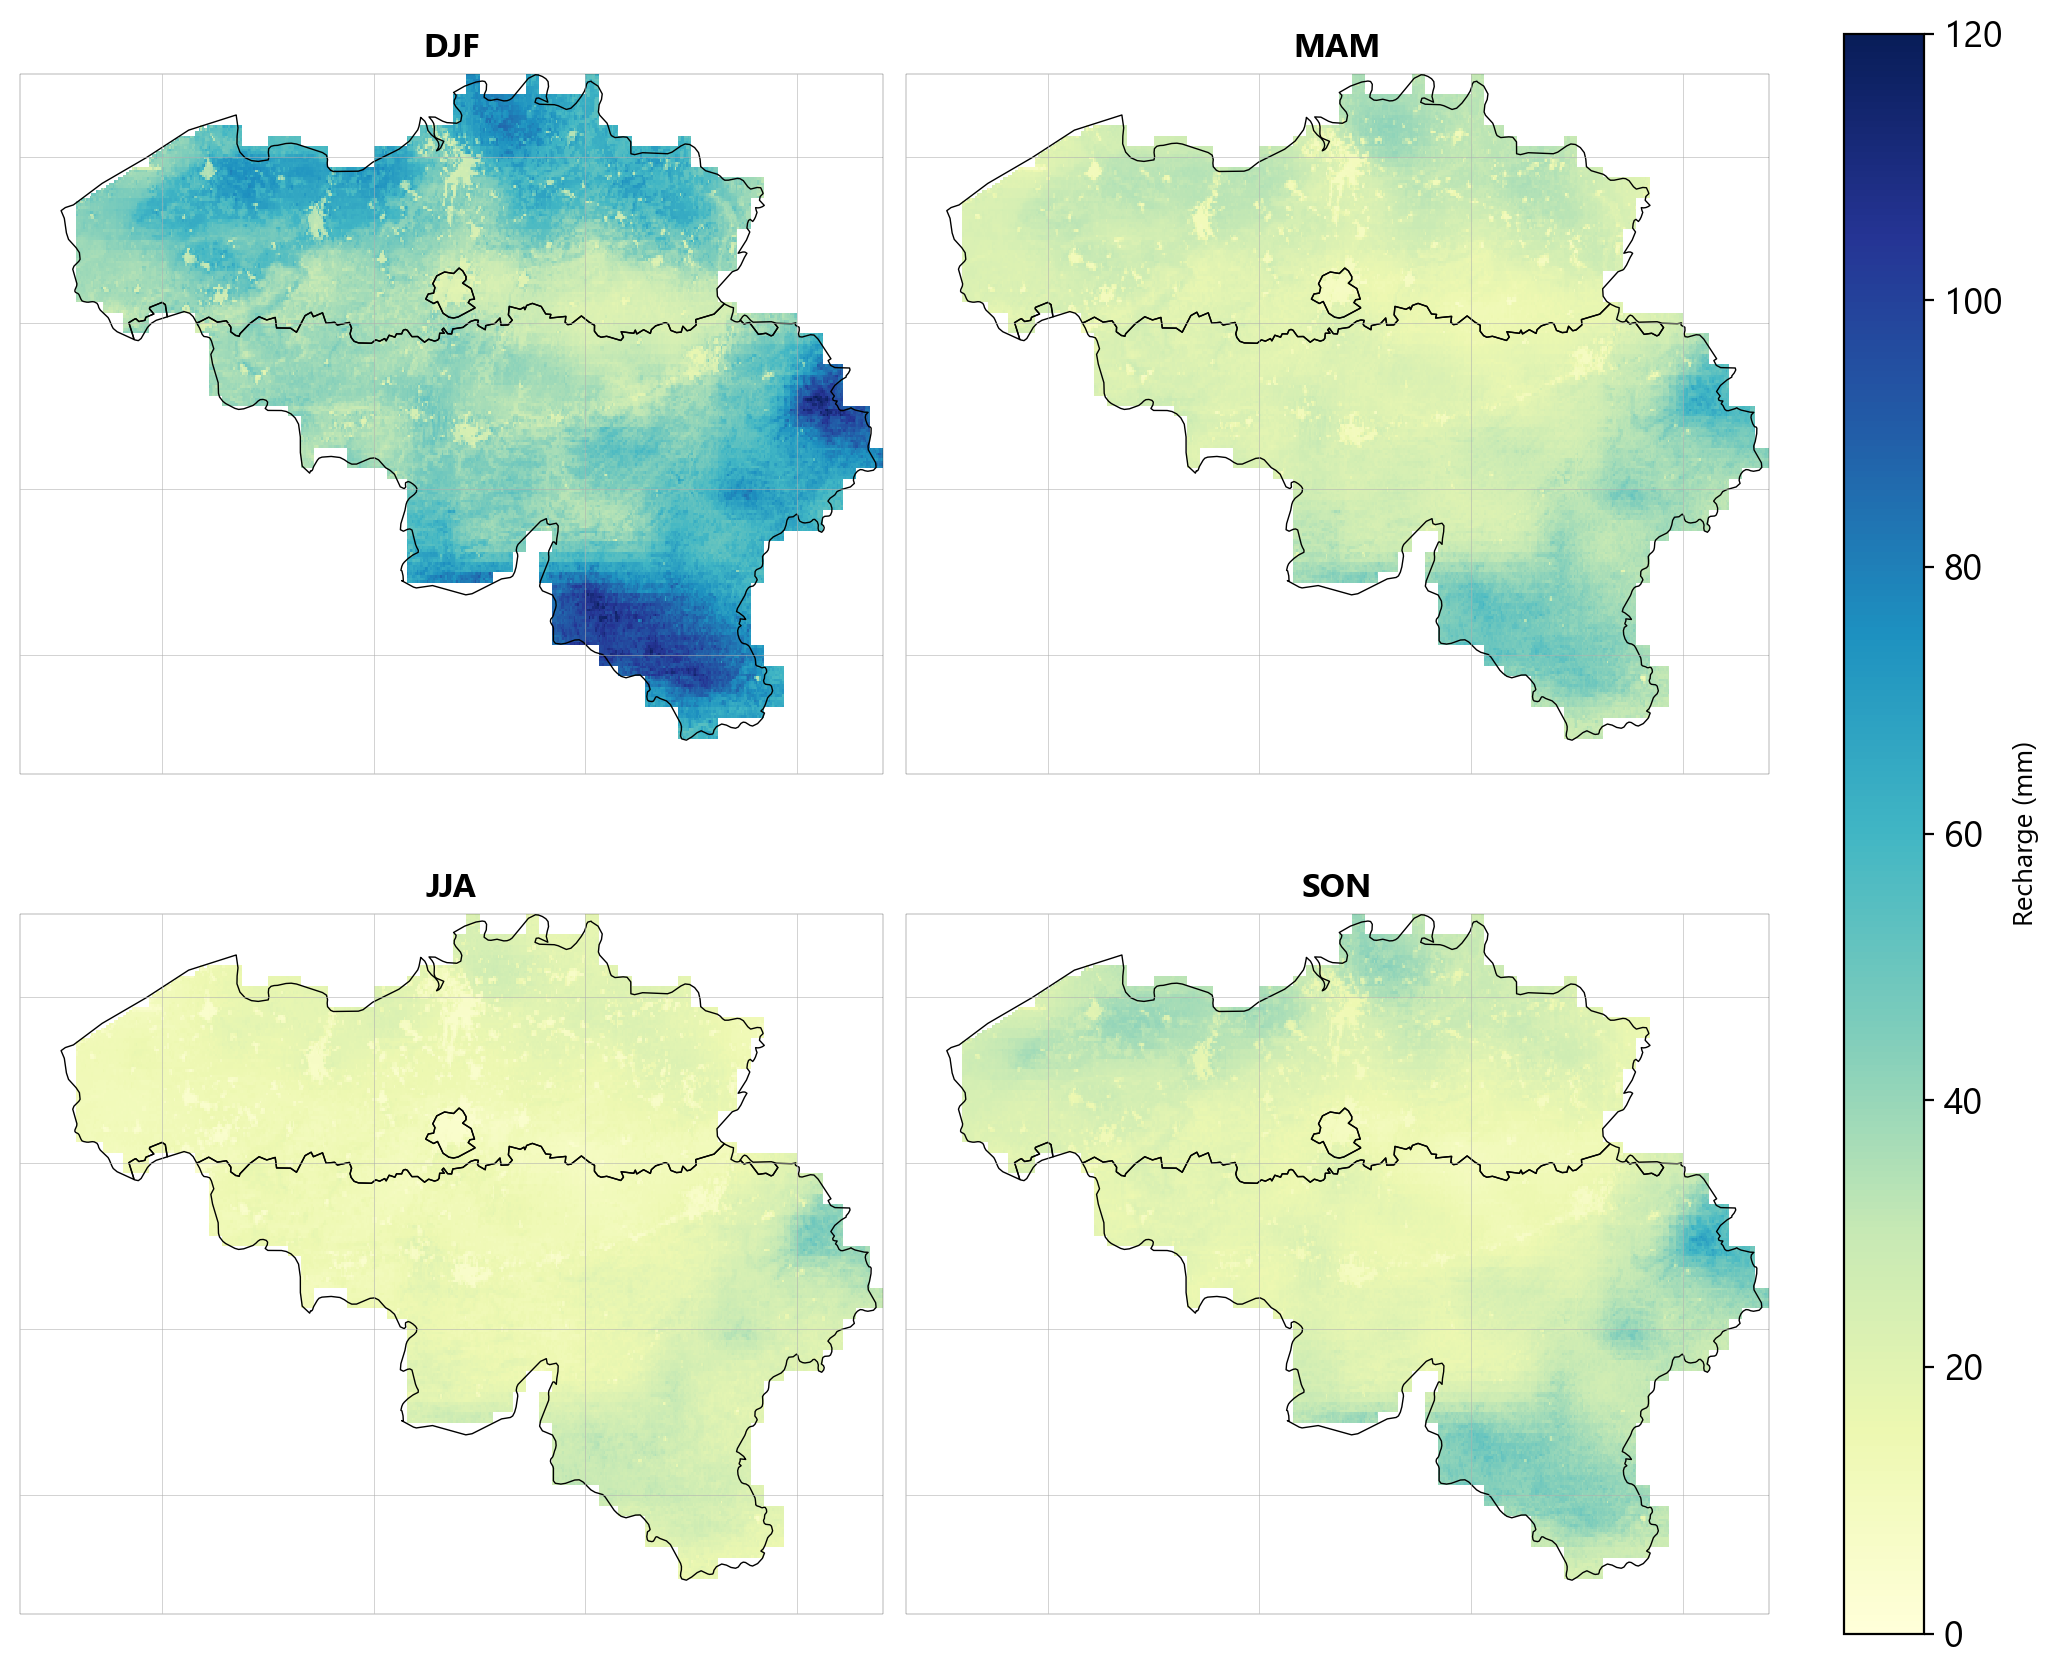

In [ ]:
### Plot seasonal recharge
# Set up the plot with Cartopy projection
ncols = 2
nrows = 2

fig, axes = plt.subplots(nrows, ncols, subplot_kw={'projection': projection}, figsize=(20, 10), dpi=200)

axes = axes.flatten()

#calculate global min and max recharge
# Calculate global min and max recharge values across all seasons
global_min_recharge = 0
global_max_recharge =120

#seasons
seasons = seasonal_recharge.keys()


#space between subplots
plt.subplots_adjust(hspace=0.2, wspace=-0.6)

#cmap
cmap = 'YlGnBu'

for idx, season in enumerate(seasons):
    ax = axes[idx]

    #select data for the season from the dictionary
    seasonal_recharge_ds = seasonal_recharge[season]['recharge']
    seasonal_recharge_masked = seasonal_recharge_ds.where(seasonal_recharge_ds > 0.01, drop=True)
    # Plot the data for the first timestep where recharge > 0
    im = seasonal_recharge_masked.plot(
        robust=True,
        ax=ax,
        vmin= global_min_recharge,
        vmax=global_max_recharge,
        cmap=cmap,
        add_colorbar=False
    )
    # Plot BE boundaries
    be_shp.boundary.plot(ax=ax, color='k', lw=.5)

    # Add latitude and longitude gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), lw=0.2, draw_labels=False)
    # Show top labels only on the first row
    gl.top_labels = False#idx < ncols
    gl.bottom_labels = False

    # Show left labels only on the first column
    gl.left_labels = False#idx % ncols == 0
    gl.right_labels = False


    # Style grid labels
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    #label spacing
    # Style grid labels with spacing adjustments
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    #set xtick labels
    gl.xlocator = mticker.FixedLocator([2, 3, 4, 5, 6])
    gl.ylocator = mticker.FixedLocator([49.75, 50.25, 50.75, 51.25])
     #change frame color
    # Change the frame thickness
    for spine in ax.spines.values():
        spine.set_linewidth(.1)  # Adjust thickness here (e.g., 2 for thicker frames)

    #set title
    ax.set_title(season, fontsize=12, fontweight='bold')

# Add a global colorbar across all subplots
cbar_ax = fig.add_axes([0.75, 0.10, 0.0, 0.80])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='Recharge (mm)')
cbar_ax.tick_params(labelsize=13)

#### Subset data for recharge zones

In [94]:
### create bounding box fro recharge zones 
recharge_zone_Ardenne = recharge.sel(lat=slice(50.5, 49.5), lon=slice(5, 6)).mean(dim = ['lat', 'lon'])
recharge_zone_Kampine = recharge.sel(lat=slice(51.5, 51), lon=slice(4.0, 6.0)).mean(dim = ['lat', 'lon'])

#preciptation zones
pre_zone_Ardenne = pre.sel(lat=slice(50.5,49.5), lon=slice(5, 6)).mean(dim = ['lat', 'lon'])
pre_zone_Kampine = pre.sel(lat=slice(51.5, 51), lon=slice(4.0, 6.0)).mean(dim = ['lat', 'lon'])
tavg_zone_Ardenne = temp.sel(lat=slice(50.5, 49.5), lon=slice(5, 6)).mean(dim = ['lat', 'lon'])
tavg_zone_Kampine = temp.sel(lat=slice(51.5, 51), lon=slice(4.0, 6.0)).mean(dim = ['lat', 'lon'])
pet_zone_Ardenne = pet.sel(lat=slice(50.5, 49.5), lon=slice(5, 6)).mean(dim = ['lat', 'lon'])
pet_zone_Kampine = pet.sel(lat=slice(51.5, 51), lon=slice(4.0, 6.0)).mean(dim = ['lat', 'lon'])

#### Cumulative recharge seasons (Sept to May)

In [155]:
# Group data into recharge seasons from Sept to May
recharge_df = recharge_zone_Ardenne['recharge'].to_dataframe()
pet_df = pet_zone_Ardenne['pet'].to_dataframe()
pre_df = pre_zone_Ardenne['pre'].to_dataframe()

# Extract data for the recharge seasons
seasons = []
for year in np.unique(recharge_df.index.year):
    # Select the data for the recharge season
    season_start = str(year) + '-09-01'
    season_end = str(year+1) + '-05-31'
    season_df = recharge_df.loc[season_start:season_end][['recharge']]
    pet_season = pet_df.loc[season_start:season_end][['pet']]
    pre_season = pre_df.loc[season_start:season_end][['pre']]

    # Add cumulative recharge
    season_df['cumulative_recharge'] = season_df['recharge'].cumsum()
    # Add cumulative pet
    season_df['cumulative_pet'] = pet_season['pet'].cumsum()
    # Add cumulative pre
    season_df['cumulative_pre'] = pre_season['pre'].cumsum()
    
    #calculate no. of days since start of recharge season as integer
    season_df['days_since_start'] = (season_df.index - season_df.index[0]).days

    #add year/year+1 to the season
    season_df['year'] = str(year) + "/" + str(year+1)
    
    #add month
    season_df['month'] = season_df.index.month
    #month names
    month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    season_df['month'] = season_df['month'].map(month_names)

    #extract date as dd/mm
    season_df['date'] = season_df.index.strftime('%d/%m')

    #set month as index
    season_df.reset_index(inplace = True)
    season_df.set_index('month', inplace = True)

    # Add the season to the list
    seasons.append(season_df)

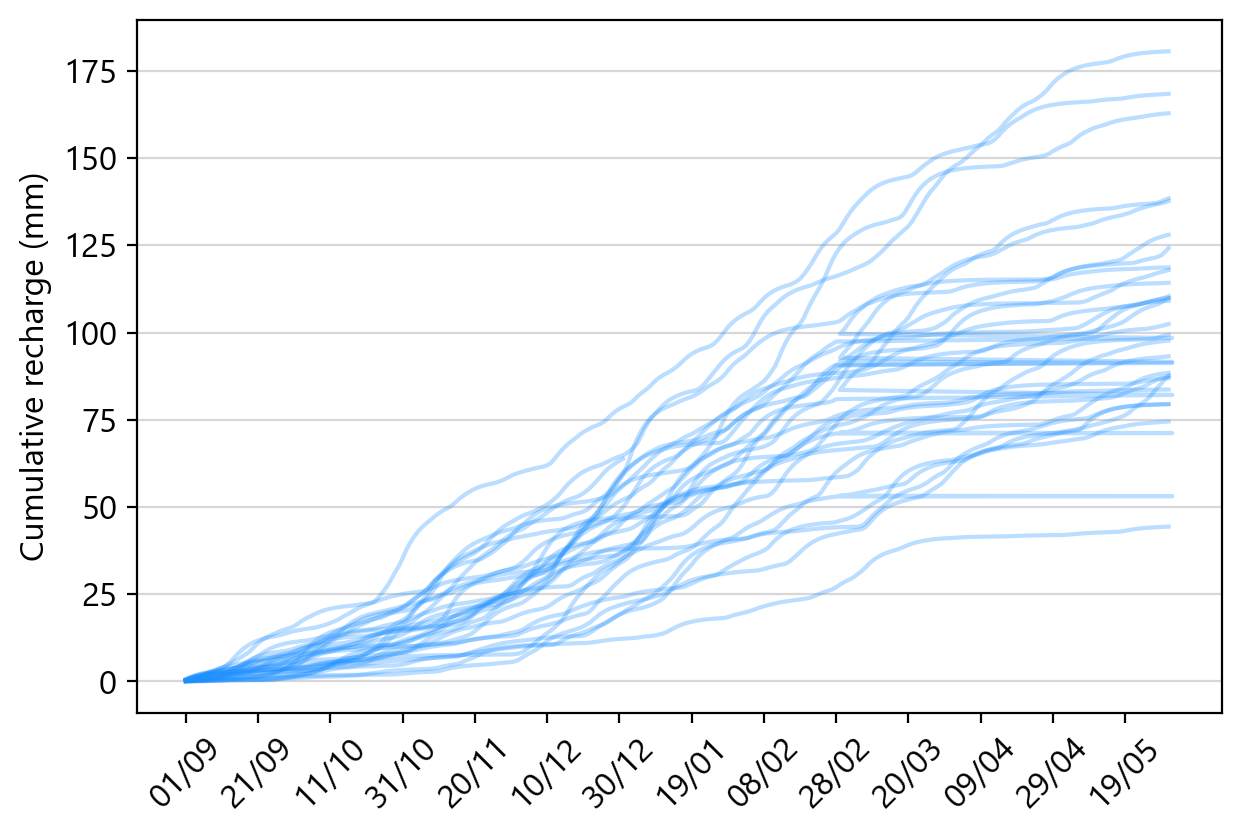

In [213]:
# Create a plotly figure for all seasons
fig,ax = plt.subplots(figsize=(7, 4.5), dpi=200)

# Loop over all seasons to plot
for season in seasons:
    t = season['date']  # Assuming 'days_since_start' holds the time variable (days since start)
    y = season['cumulative_recharge']  # Assuming 'cumulative_recharge' holds the recharge values

    #rate of change in recharge
    season['recharge_rate'] = season['recharge'].diff()

    # Plot the data
    ax.plot(t, y, label=season['year'].iloc[0], c = 'dodgerblue', alpha = 0.3)

    #plot the rate of change in recharge
    #ax.plot(t, season['recharge_rate'], label=season['year'].iloc[0], c = 'r', alpha = 0.3)

    #plot data for the last season
    t = seasons[-1]['date']
    y = seasons[-1]['cumulative_recharge']
    #ax.plot(t, y, label=seasons[0]['year'].iloc[0], c = 'r', alpha = 0.1, lw = 1)

#ax.set_xlabel('Date') #or perhaps 21st of Sept

#12 labels on x axis
ax.set_xticks(np.arange(0, 270, 20))
ax.set_xticklabels(seasons[0]['date'][::20], rotation=45)
ax.grid(axis='y', alpha=0.5)

ax.set_ylabel('Cumulative recharge (mm)', fontsize=12)
#size of y ticks
ax.tick_params(axis='both', labelsize=12)

#### Drought data for presentation (to be removed)

In [97]:
drought = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mhm_RMI\drought_SM_Lall_data.nc")
smi_EDO = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mhm_RMI\drought_analysis\scaled_paw.nc")

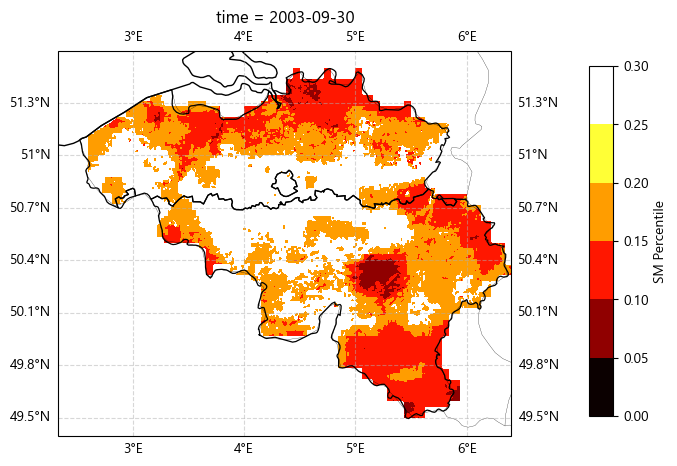

In [98]:
# Let's plot the first timestep where recharge > 0

# Create a mask for values where recharge > 0
recharge_ds = drought['Percentile'].sel(time = '2003-09-30')
recharge_masked = recharge_ds.where(recharge_ds<.20, drop=True)

# Set the projection
projection = ccrs.PlateCarree()

# Set up the plot with Cartopy projection
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(6, 5), dpi=100)

# Add gridlines
gl = ax.gridlines(crs=projection, draw_labels=True, linestyle='--', alpha=0.5)
gl.xlabels_top = False

#define custom color palette
#cmap = matplotlib.colors.ListedColormap(['#ff7f0e', '#FFFF00', '#BBF90F', '#00FF00','#15B01A','#029386','#069AF3'])
cmap = 'hot'

# Plot the data for the first timestep where recharge > 0
im = recharge_masked.plot.contourf(
    robust=True,
    vmin=0,
    vmax=0.3,
    ax=ax,
    cmap=cmap,
    add_colorbar=False
)

# Add coastlines
ax.coastlines()
# Add political boundaries (will display global borders)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), lw=0.2)

# Plot Belgium's boundaries
be_shp.boundary.plot(ax=ax, color='k', lw=.9)

#add cb
cbar_ax = fig.add_axes([1.02, 0.15, 0.04, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='SM Percentile')
cbar_ax.tick_params(labelsize=10)

# Show the plot
plt.show()

In [99]:
df

,lon,lat,week,SWC_L03
time,,,,
1996-01-07,5.503906,51.003906,0,2.112449
1996-01-14,5.503906,51.003906,1,2.126395
1996-01-21,5.503906,51.003906,2,2.119029
1996-01-28,5.503906,51.003906,3,2.096017
1996-02-04,5.503906,51.003906,4,2.080628
...,...,...,...,...
2023-12-09,5.503906,51.003906,48,2.289037
2023-12-16,5.503906,51.003906,49,2.290795
2023-12-23,5.503906,51.003906,50,2.289532


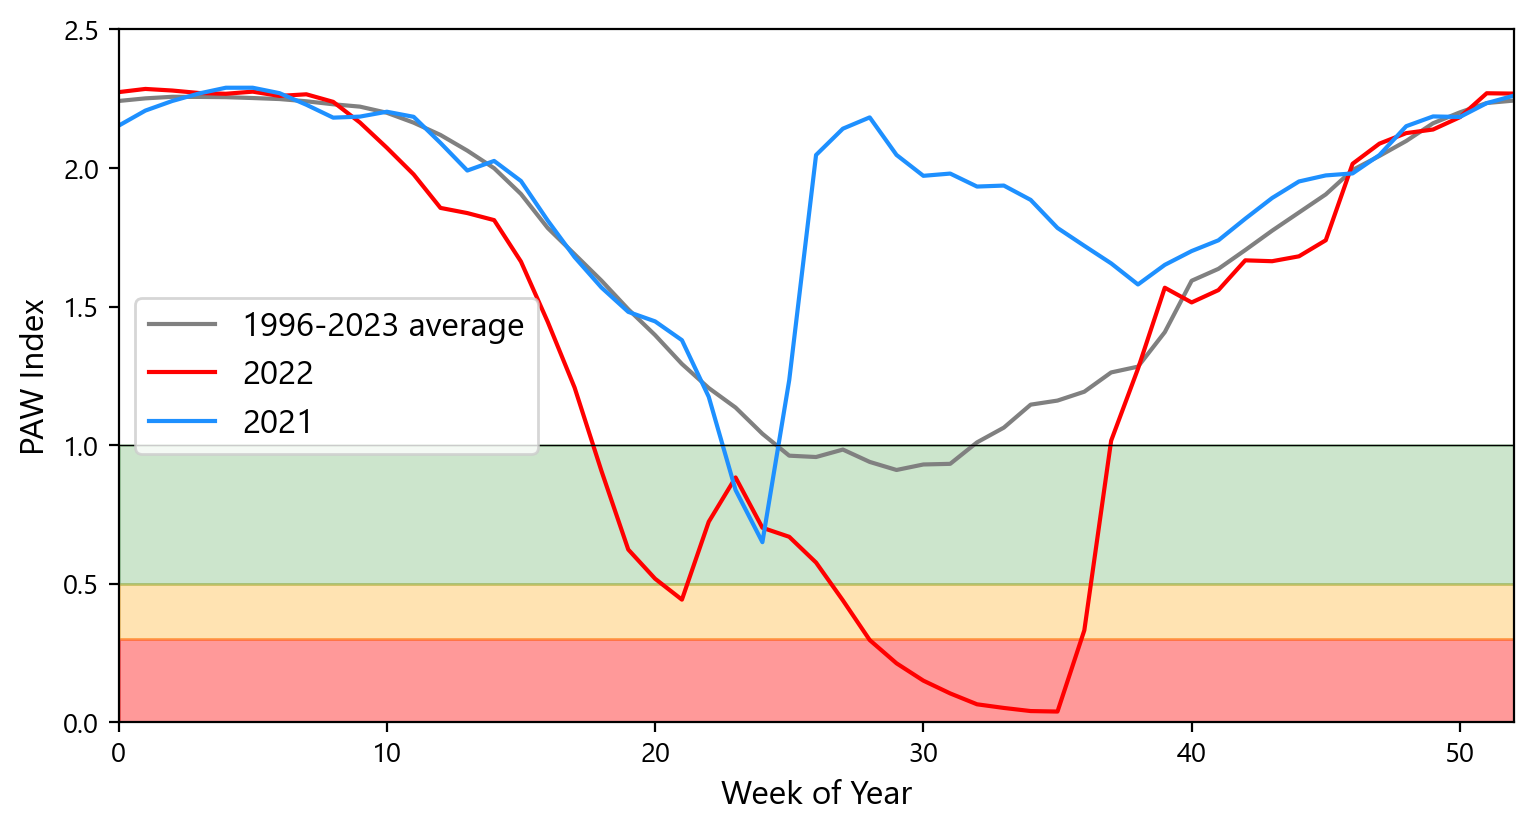

In [100]:
#scale SMI between 0 and 1
#where SMI>1, set to 1
#smi_EDO['SWC_L02'] = smi_EDO['SWC_L02'].where(smi_EDO['SWC_L02'] < 1, 1)


df = smi_EDO['SWC_L03'].sel(lat=51, lon=5.5, method='nearest').to_dataframe()
#groupby week
df_week = df.groupby('week').mean()
df_2022 = df.loc['2022-01-01':'2022-12-31']
df_2022_week = df_2022.groupby('week').mean()
df_2021 = df.loc['2021-01-01':'2021-12-31']
df_2021_week = df_2021.groupby('week').mean()
df_2018 = df.loc['2018-01-01':'2018-12-31']
df_2018_week = df_2018.groupby('week').mean()
df_2023 = df.loc['2023-01-01':'2023-12-31']
df_2023_week = df_2023.groupby('week').mean()


#plot
fig, ax = plt.subplots(figsize=(9, 4.5), dpi = 200)
ax.plot(df_week['SWC_L03'], label = '1996-2023 average', c = 'gray')
ax.plot(df_2022_week['SWC_L03'], label = '2022', c = 'r')
ax.plot(df_2021_week['SWC_L03'], label = '2021', c = 'dodgerblue')
#ax.plot(df_2018_week['SWC_L03'], label = '2018', c = 'b')
#ax.plot(df_2023_week['SWC_L03'], label = '2023', c = 'm')

#shade drought periods: fill between 0 and 0.3, 0.3 and 0.5 0.5 to 1
ax.fill_between(df_week.index, 0, 0.3, color='red', alpha=0.4)
ax.fill_between(df_week.index, 0.3, 0.5, color='orange', alpha=0.3)
ax.fill_between(df_week.index, 0.5, 1, color='green', alpha=0.2)
ax.axhline(1, color='k', lw=0.5)
ax.set_xlim(0, 52)
ax.set_ylim(0, 2.5)
ax.set_ylabel('PAW Index', fontsize=12)
ax.set_xlabel('Week of Year', fontsize=12)
ax.legend( loc = 'center left', ncols = 1, fontsize = 12)


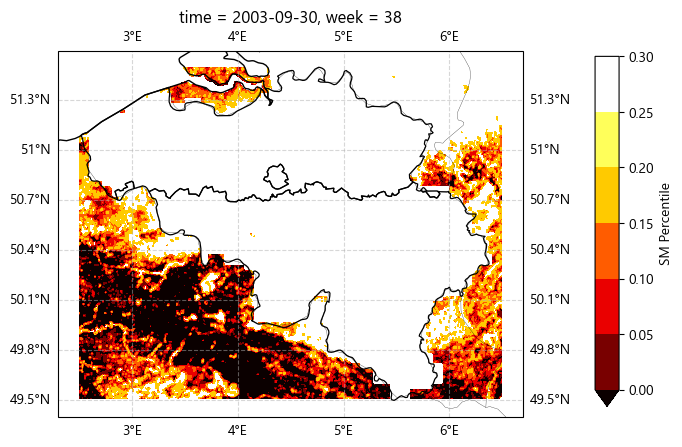

In [102]:
# Let's plot the first timestep where recharge > 0

# Create a mask for values where recharge > 0
recharge_ds =smi_EDO['SWC_L03'].sel(time = '2003-09-30')
recharge_masked = recharge_ds.where(recharge_ds<.20, drop=True)

# Set the projection
projection = ccrs.PlateCarree()

# Set up the plot with Cartopy projection
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(6, 5), dpi=100)

# Add gridlines
gl = ax.gridlines(crs=projection, draw_labels=True, linestyle='--', alpha=0.5)
gl.xlabels_top = False

#define custom color palette
#cmap = matplotlib.colors.ListedColormap(['#ff7f0e', '#FFFF00', '#BBF90F', '#00FF00','#15B01A','#029386','#069AF3'])
cmap = 'hot'

# Plot the data for the first timestep where recharge > 0
im = recharge_masked.plot.contourf(
    robust=True,
    vmin=0,
    vmax=0.3,
    ax=ax,
    cmap=cmap,
    add_colorbar=False
)

# Add coastlines
ax.coastlines()
# Add political boundaries (will display global borders)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), lw=0.2)

# Plot Belgium's boundaries
be_shp.boundary.plot(ax=ax, color='k', lw=.9)

#add cb
cbar_ax = fig.add_axes([1.02, 0.15, 0.04, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='SM Percentile')
cbar_ax.tick_params(labelsize=10)

# Show the plot
plt.show()